In [2]:
import pandas as pd


df_1 = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/work_dirs/reproduce-mgoksu-deotte/train_data_1_and_2_final/train_data_final.csv")
df_2 = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/cdeotte-60k-data-with-context-v2/all_12_with_context2.csv")

df = pd.concat([df_1, df_2], axis=0, ignore_index=True)

# REPLACE nan with empty string
df = df.fillna("")

df

,prompt,context,A,B,C,D,E,answer,source
0,What is the main focus of GLP1R in the brain?,GLP1R is also expressed in the brain where it ...,To regulate blood sugar level by increasing gl...,To control appetite and stimulate weight gain,To enhance insulin synthesis and release,To improve memory and learning,To inhibit insulin synthesis and release,D,
1,What is the interpretation of GLP1R being expr...,Stretch responsive vagal neurons in the stomac...,It controls appetite and weight gain,It enhances insulin synthesis and release,It regulates glucagon synthesis and release,It communicates with additional organ systems ...,It improves memory and learning,D,
2,What is the function of GFRα3?,"GDNF family receptor alpha-3 (GFRα3), also kno...",To bind to artemin ligand,To form a signaling receptor complex with RET ...,To prevent artemin from binding and signaling ...,To upregulate in sensory nerves,To use their limbs again two hours post-treatment,A,
3,What is the receptor that GFRα3 forms a signal...,"GDNF family receptor alpha-3 (GFRα3), also kno...",GFRα,Glycosylphosphatidylinositol (GPI),RET tyrosine kinase receptor,Artemin ligand,Monoclonal antibodies,C,
4,What is the significance of GFRα3 being upregu...,"In mouse models of osteoarthritis, GFRα3 was u...",It prevents artemin from binding and signaling...,It forms a signaling receptor complex with RET...,It binds to the artemin ligand,It allows mice to use their limbs again two ho...,It is a glycosylphosphatidylinositol(GPI)-link...,A,
...,...,...,...,...,...,...,...,...,...
160470,"The outer ear, or ear canal, carries sound to ...","The ear canal (external acoustic meatus, exter...",aorta,ear lobe,eardrum,lungs,,C,12.0
160471,What sport involves people quickly finding des...,Orienteering sports in which route choice is a...,mapping,,orienteering,patterning,sticking,C,12.0
160472,Almost all earthquakes occur at which place?,This subduction zone led to the formation of t...,mountains,land boundaries,plate boundaries,continental shelf,,C,12.0
160473,"Melting glaciers, rising temperatures and drou...",Impacts include changes in regional rainfall p...,nature's natural cycle,air pollution,global warming,sudden warming,,C,12.0


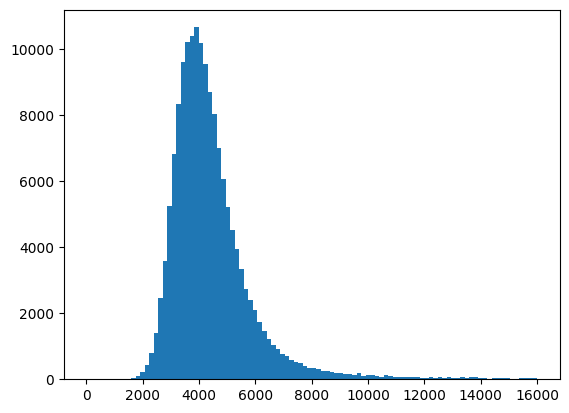

In [4]:
df['context_len'] = df['context'].apply(lambda x: len(x))

import matplotlib.pyplot as plt

plt.hist(df['context_len'], bins=100, range=(0, 16000));

In [3]:
import numpy as np
import pandas as pd 
from datasets import load_dataset, load_from_disk
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import LongformerTokenizer, LongformerForMultipleChoice
import transformers
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import unicodedata

import os


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 121
CUDA SETUP: Loading binary /home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda121.so...


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /home/viktor/miniconda3/envs/torch-env did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess')}
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//matplotlib_inline.backend_inline'), PosixPath('module')}
  warn(msg)


In [4]:
stop_words = ['each', 'you', 'the', 'use', 'used',
                  'where', 'themselves', 'nor', "it's", 'how', "don't", 'just', 'your',
                  'about', 'himself', 'with', "weren't", 'hers', "wouldn't", 'more', 'its', 'were',
                  'his', 'their', 'then', 'been', 'myself', 're', 'not',
                  'ours', 'will', 'needn', 'which', 'here', 'hadn', 'it', 'our', 'there', 'than',
                  'most', "couldn't", 'both', 'some', 'for', 'up', 'couldn', "that'll",
                  "she's", 'over', 'this', 'now', 'until', 'these', 'few', 'haven',
                  'of', 'wouldn', 'into', 'too', 'to', 'very', 'shan', 'before', 'the', 'they',
                  'between', "doesn't", 'are', 'was', 'out', 'we', 'me',
                  'after', 'has', "isn't", 'have', 'such', 'should', 'yourselves', 'or', 'during', 'herself',
                  'doing', 'in', "shouldn't", "won't", 'when', 'do', 'through', 'she',
                  'having', 'him', "haven't", 'against', 'itself', 'that',
                  'did', 'theirs', 'can', 'those',
                  'own', 'so', 'and', 'who', "you've", 'yourself', 'her', 'he', 'only',
                  'what', 'ourselves', 'again', 'had', "you'd", 'is', 'other',
                  'why', 'while', 'from', 'them', 'if', 'above', 'does', 'whom',
                  'yours', 'but', 'being', "wasn't", 'be']

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata


def SplitList(mylist, chunk_size):
    return [mylist[offs:offs+chunk_size] for offs in range(0, len(mylist), chunk_size)]

def get_relevant_documents_parsed(df_valid):
    df_chunk_size=600
    if RUN_ON_KAGGLE:
        paraphs_parsed_dataset = load_from_disk("/kaggle/working/all-paraphs-parsed-expanded")
    else:
        paraphs_parsed_dataset = load_from_disk("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/all-paraphs-parsed-expanded")
    
    modified_texts = paraphs_parsed_dataset.map(lambda example:
                                             {'temp_text':
                                              f"{example['title']} {example['section']} {example['text']}".replace('\n'," ").replace("'","")},
                                             num_proc=2)["temp_text"]
    
    all_articles_indices = []
    all_articles_values = []
    for idx in tqdm(range(0, df_valid.shape[0], df_chunk_size)):
        df_valid_ = df_valid.iloc[idx: idx+df_chunk_size]
    
        articles_indices, merged_top_scores = retrieval(df_valid_, modified_texts)
        all_articles_indices.append(articles_indices)
        all_articles_values.append(merged_top_scores)
        
    article_indices_array =  np.concatenate(all_articles_indices, axis=0)
    articles_values_array = np.concatenate(all_articles_values, axis=0).reshape(-1)
    
    top_per_query = article_indices_array.shape[1]
    articles_flatten = [(
                         articles_values_array[index],
                         paraphs_parsed_dataset[idx.item()]["title"],
                         paraphs_parsed_dataset[idx.item()]["text"],
                        )
                        for index,idx in enumerate(article_indices_array.reshape(-1))]
    retrieved_articles = SplitList(articles_flatten, top_per_query)
    return retrieved_articles



def get_relevant_documents(df_valid):
    df_chunk_size=800
    if RUN_ON_KAGGLE:
        cohere_dataset_filtered = load_from_disk("/kaggle/working/stem-wiki-cohere-no-emb")
    else:
        cohere_dataset_filtered = load_from_disk("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wiki-stem-cohere")
    modified_texts = cohere_dataset_filtered.map(lambda example:
                                             {'temp_text':
                                              unicodedata.normalize("NFKD", f"{example['title']} {example['text']}").replace('"',"")},
                                             num_proc=2)["temp_text"]
    
    all_articles_indices = []
    all_articles_values = []
    for idx in tqdm(range(0, df_valid.shape[0], df_chunk_size)):
        df_valid_ = df_valid.iloc[idx: idx+df_chunk_size]
    
        articles_indices, merged_top_scores = retrieval(df_valid_, modified_texts)
        all_articles_indices.append(articles_indices)
        all_articles_values.append(merged_top_scores)
        
    article_indices_array =  np.concatenate(all_articles_indices, axis=0)
    articles_values_array = np.concatenate(all_articles_values, axis=0).reshape(-1)
    
    top_per_query = article_indices_array.shape[1]
    articles_flatten = [(
                         articles_values_array[index],
                         cohere_dataset_filtered[idx.item()]["title"],
                         unicodedata.normalize("NFKD", cohere_dataset_filtered[idx.item()]["text"]),
                        )
                        for index,idx in enumerate(article_indices_array.reshape(-1))]
    retrieved_articles = SplitList(articles_flatten, top_per_query)
    return retrieved_articles



def retrieval(df_valid, modified_texts):
    
    corpus_df_valid = df_valid.apply(lambda row:
                                     f'{row["prompt"]}\n{row["prompt"]}\n{row["prompt"]}\n{row["A"]}\n{row["B"]}\n{row["C"]}\n{row["D"]}\n{row["E"]}',
                                     axis=1).values
    vectorizer1 = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words)
    vectorizer1.fit(corpus_df_valid)
    vocab_df_valid = vectorizer1.get_feature_names_out()
    vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words,
                                 vocabulary=vocab_df_valid)
    vectorizer.fit(modified_texts[:500000])
    corpus_tf_idf = vectorizer.transform(corpus_df_valid)
    
    print(f"length of vectorizer vocab is {len(vectorizer.get_feature_names_out())}")

    chunk_size = 100000
    top_per_chunk = 10
    top_per_query = 10

    all_chunk_top_indices = []
    all_chunk_top_values = []

    for idx in tqdm(range(0, len(modified_texts), chunk_size)):
        wiki_vectors = vectorizer.transform(modified_texts[idx: idx+chunk_size])
        temp_scores = (corpus_tf_idf * wiki_vectors.T).toarray()
        chunk_top_indices = temp_scores.argpartition(-top_per_chunk, axis=1)[:, -top_per_chunk:]
        chunk_top_values = temp_scores[np.arange(temp_scores.shape[0])[:, np.newaxis], chunk_top_indices]

        all_chunk_top_indices.append(chunk_top_indices + idx)
        all_chunk_top_values.append(chunk_top_values)

    top_indices_array = np.concatenate(all_chunk_top_indices, axis=1)
    top_values_array = np.concatenate(all_chunk_top_values, axis=1)
    
    merged_top_scores = np.sort(top_values_array, axis=1)[:,-top_per_query:]
    merged_top_indices = top_values_array.argsort(axis=1)[:,-top_per_query:]
    articles_indices = top_indices_array[np.arange(top_indices_array.shape[0])[:, np.newaxis], merged_top_indices]
    
    return articles_indices, merged_top_scores


def prepare_answering_input(
        tokenizer, 
        question,  
        options,   
        context,   
        max_seq_length=4096,
    ):
    c_plus_q   = context + ' ' + tokenizer.bos_token + ' ' + question
    c_plus_q_4 = [c_plus_q] * len(options)
    tokenized_examples = tokenizer(
        c_plus_q_4, options,
        max_length=max_seq_length,
        padding="longest",
        truncation=False,
        return_tensors="pt",
    )
    input_ids = tokenized_examples['input_ids'].unsqueeze(0)
    attention_mask = tokenized_examples['attention_mask'].unsqueeze(0)
    example_encoded = {
        "input_ids": input_ids.to(model.device.index),
        "attention_mask": attention_mask.to(model.device.index),
    }
    return example_encoded

In [8]:
retrieved_articles = get_relevant_documents(df)
gc.collect()

Loading cached processed dataset at /home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wiki-stem-cohere/cache-e94d488c6798573e_*_of_00002.arrow
  0%|          | 0/1 [00:00<?, ?it/s]

length of vectorizer vocab is 6132


100%|██████████| 1/1 [01:27<00:00, 87.15s/it]


0

In [9]:

contexts = []

for index in tqdm(range(df.shape[0])):
    row = df.iloc[index]
    # question is 'prompt'
    question = row['prompt']
    options = [row['A'], row['B'], row['C'], row['D'], row['E']]
    context = f"{retrieved_articles[index][-4][2]}\n{retrieved_articles[index][-3][2]}\n{retrieved_articles[index][-2][2]}\n{retrieved_articles[index][-1][2]}"
    contexts.append(context)

100%|██████████| 100/100 [00:00<00:00, 29341.06it/s]


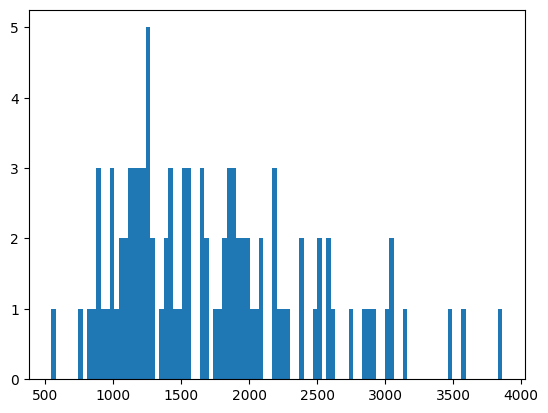

In [10]:
df['context'] = contexts
df['context_len'] = df['context'].apply(lambda x: len(x))

plt.hist(df['context_len'], bins=100);

In [12]:
df.to_parquet('./test_context.parquet')

In [7]:
import numpy as np

x = 10 + np.random.randn(5)
x = (x - np.min(x)) / (np.max(x) - np.min(x))
x

array([0.        , 0.62120737, 1.        , 0.97467856, 0.13408028])